# Google Analytics Revenue Prediction

## Model Selection

**Environment**

In [41]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
from myfunctions import *

**Import Dataframe**

In [3]:
df = pd.read_csv("data/df5-1.csv", low_memory=False)

In [4]:
df.shape

(903455, 50)

In [5]:
df.head()

,channel_direct,channel_organic,channel_other,channel_paid,browser_android,browser_chrome,browser_firefox,browser_microsoft,browser_other,cat_desktop,cat_mobile,os_Android,os_Macintosh,os_Windows,os_iOS,continet_Africa,continet_Americas,continet_Asia,continet_Europe,continet_Oceania,ad_GoogleMerchandiseCollection,ad_NoAd,network_Google Search,network_NoAdWords,campaign_AW,campaign_Data Share,campaign_NoCampaign,medium_affiliate,medium_cpc,medium_cpm,medium_none,medium_organic,medium_other,referral_Google,referral_Home,referral_NoReferral,referral_Youtube,source_Google,source_Googleplex,source_Youtube,source_direct,visitNumber,deviceIsMobile,totalsBounces,totalsNewVisits,totalsPageviews,adwordsClickGclId,trafficSourceIsTrueDirect,newRandom,newConversion
0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.581066,0
1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.476443,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.502763,0
3,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0.735265,0
4,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,2,1,1,0,1,0,1,0.238397,0


In [6]:
df.columns

Index(['channel_direct', 'channel_organic', 'channel_other', 'channel_paid',
       'browser_android', 'browser_chrome', 'browser_firefox',
       'browser_microsoft', 'browser_other', 'cat_desktop', 'cat_mobile',
       'os_Android', 'os_Macintosh', 'os_Windows', 'os_iOS', 'continet_Africa',
       'continet_Americas', 'continet_Asia', 'continet_Europe',
       'continet_Oceania', 'ad_GoogleMerchandiseCollection', 'ad_NoAd',
       'network_Google Search', 'network_NoAdWords', 'campaign_AW',
       'campaign_Data Share', 'campaign_NoCampaign', 'medium_affiliate',
       'medium_cpc', 'medium_cpm', 'medium_none', 'medium_organic',
       'medium_other', 'referral_Google', 'referral_Home',
       'referral_NoReferral', 'referral_Youtube', 'source_Google',
       'source_Googleplex', 'source_Youtube', 'source_direct', 'visitNumber',
       'deviceIsMobile', 'totalsBounces', 'totalsNewVisits', 'totalsPageviews',
       'adwordsClickGclId', 'trafficSourceIsTrueDirect', 'newRandom',
       

### Model Selection

In the model selection process I will take into account:<br>
    1.- It is a binaty classification problem<br>
    2.- The data is Sparse<br>
    3.- The target is very unbalanced (1,29% vs 98,71)<br>
    4.- There is a lot of data 903455 rows and 48 columns<br>

**CONCLUSIONS:**<br>
1.- I'll use a decision tree<br>
2.- I'll try to balance the classes down sampling the data<br>
3.- I'll use Under ROC Curve (AUROC) as metric<br>

### Down sampling the dataframe

I'll separate observations from each class into different DataFrames.


In [7]:
# Separate majority and minority classes
df_majority = df[df.newConversion==0]
df_minority = df[df.newConversion==1]

In [8]:
df_majority.shape

(891940, 50)

In [9]:
df_minority.shape

(11515, 50)

I'll resample the majority class without replacement, setting the number of samples to match that of the minority class.


In [10]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=11515,     # to match minority class
                                 random_state=123) # reproducible results
 

I'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

In [11]:
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [12]:
df_downsampled['newConversion'].value_counts()

1    11515
0    11515
Name: newConversion, dtype: int64

In [13]:
df_downsampled.shape

(23030, 50)

In [14]:
df_downsampled.isnull().sum().sum()

0

In [15]:
df_downsampled.to_csv("data/df5_1-downsampled.csv",index=False)

### Classification Tree: Random Forrest

#### Split dataframe

In [16]:
X = df_downsampled.iloc[:,:-1]
y = df_downsampled.iloc[:,-1:]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.2, random_state=10)

#### Search Grid Cross Validation

In [18]:
rfc = RandomForestClassifier(random_state=10)

In [19]:
#Current parameters of Random Forrest Classifier
print(rfc.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


I'll use the following parameters to hypertune the model

n_estimators = number of trees in the foreset<br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
bootstrap = method for sampling data points (with or without replacement)<br>
criterion = the function to measure the quality of a split

In [20]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'bootstrap' : [True, False],
    'criterion': ['gini', 'entropy']   
}

In [21]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=8)

In [22]:
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.956, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.957, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.950, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.952, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.950, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.950, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.945, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.942, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.944, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.954, total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.956, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.957, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.950, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.952, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.950, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.950, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.950, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.945, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.942, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.944, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.906, total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.910, total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.913, total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.858, total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.930, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.934, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.926, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.923, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.919, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.929, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.929, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.924, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.922, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.915, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.926, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.960, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.944, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.933, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.959, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.953, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.957, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.960, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.951, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.954, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.956, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.960, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.944, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.933, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.959, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.957, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.960, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.951, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.954, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.956, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.949, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.949, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.938, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.959, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.953, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.955, total=   0.2s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.951, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.944, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.951, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.948, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.960, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.958, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.959, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.957, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.960, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.958, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.959, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.957, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.938, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.958, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.960, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.954, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.958, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.959, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.951, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.954, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.956, total=   0.5s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.961, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.962, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.951, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.958, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.961, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.952, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.955, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.961, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.962, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.951, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.958, total=   0.4s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.961, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.952, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.955, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   0.7s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.959, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.952, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.952, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.958, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.960, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.952, total=   0.6s
[CV] bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.956, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.953, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.955, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.948, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.950, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.954, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.941, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.941, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.943, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.953, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.955, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.948, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.951, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.950, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.941, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.941, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.943, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.909, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.911, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.903, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.894, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.938, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.933, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.927, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.927, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.918, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.931, total=   0.2s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.931, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.926, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.925, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.915, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.931, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.946, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.940, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.949, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.951, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.953, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.959, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.949, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.955, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.946, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.940, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.954, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.949, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.955, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.953, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.959, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.949, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.955, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.938, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.941, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.941, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.939, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.948, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.949, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.953, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.949, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.951, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.943, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.943, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.952, total=   0.9s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.959, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.958, total=   1.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.952, total=   1.2s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.959, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.954, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.957, total=   0.9s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.945, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.957, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.952, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.957, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.958, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.952, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.952, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.955, total=   0.6s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.960, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.956, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.959, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.952, total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.960, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.956, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.959, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   0.9s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   0.9s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   0.9s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.945, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.956, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.958, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.956, total=   0.4s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.959, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=True, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.955, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=10, score=0.932, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.955, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.956, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=50, score=0.945, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.953, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.942, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.943, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=auto, n_estimators=100, score=0.944, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=10, score=0.932, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.955, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.956, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.950, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=50, score=0.945, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.954, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.953, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.942, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.943, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100, score=0.944, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.914, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.917, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.910, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.903, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=10, score=0.908, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.933, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.926, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.923, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.920, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=50, score=0.923, total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.930, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.923, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.922, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.915, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=log2, n_estimators=100, score=0.921, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.945, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.949, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=10, score=0.939, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.960, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.950, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.959, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.950, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.953, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=auto, n_estimators=100, score=0.955, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.945, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.949, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=10, score=0.939, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.960, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.950, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.959, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.950, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.953, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100, score=0.955, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.944, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.944, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.935, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.918, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=10, score=0.929, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.958, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.945, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.943, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.957, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.950, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.941, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=5, max_features=log2, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.960, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.951, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.954, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.957, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.961, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.954, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=auto, n_estimators=100, score=0.957, total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.943, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=10, score=0.958, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.960, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.951, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.957, total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.961, total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.954, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100, score=0.957, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.946, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.948, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.938, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.958, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.951, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.959, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.952, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=7, max_features=log2, n_estimators=100, score=0.956, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.957, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.960, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.951, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.956, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.960, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.955, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=auto, n_estimators=100, score=0.958, total=   1.5s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=10, score=0.954, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.957, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.960, total=   0.7s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.956, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=50, score=0.958, total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.960, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.951, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.955, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=sqrt, n_estimators=100, score=0.958, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.950, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.957, total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.958, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.951, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.954, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=gini, max_depth=9, max_features=log2, n_estimators=100, score=0.957, total=   1.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.956, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.953, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.955, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.949, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.949, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=50, score=0.945, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.945, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.948, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.938, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.941, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, n_estimators=100, score=0.943, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.953, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.955, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.949, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.949, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=50, score=0.945, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.945, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.948, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.938, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.941, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=sqrt, n_estimators=100, score=0.943, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.918, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.917, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.903, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.906, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=10, score=0.893, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.935, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.929, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.926, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.919, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=50, score=0.927, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.934, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.929, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.925, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.923, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=log2, n_estimators=100, score=0.925, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.940, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.944, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.946, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.953, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.950, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.954, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.958, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.950, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=auto, n_estimators=100, score=0.953, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.940, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.944, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.946, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.942, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=10, score=0.950, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.950, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.952, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=50, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.954, total=   1.0s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.958, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.950, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.951, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100, score=0.953, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.935, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.927, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.928, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.949, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=10, score=0.927, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.954, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.948, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.951, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=50, score=0.954, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.951, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.943, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.950, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=5, max_features=log2, n_estimators=100, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.957, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=50, score=0.955, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.958, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.961, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.954, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=auto, n_estimators=100, score=0.955, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=10, score=0.957, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.958, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.952, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.955, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=50, score=0.955, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.958, total=   1.0s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.961, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.952, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.954, total=   1.0s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, score=0.955, total=   0.9s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.931, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.947, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=10, score=0.951, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.960, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.950, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=50, score=0.954, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.957, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.959, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.951, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=7, max_features=log2, n_estimators=100, score=0.954, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.961, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.952, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.954, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=50, score=0.957, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.957, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.961, total=   1.2s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.951, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.954, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=auto, n_estimators=100, score=0.955, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.959, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.955, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.957, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.961, total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.952, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.954, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=50, score=0.957, total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.957, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.961, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.951, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.954, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=sqrt, n_estimators=100, score=0.955, total=   1.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.956, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.953, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.952, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=10, score=0.945, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.957, total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.959, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.953, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.952, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=50, score=0.955, total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.957, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.959, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.952, total=   0.8s
[CV] bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100 


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  bootstrap=False, criterion=entropy, max_depth=9, max_features=log2, n_estimators=100, score=0.955, total=   0.8s


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  4.7min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [23]:
CV_rfc.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 100}

In [24]:
rfc_best=RandomForestClassifier(random_state=10, max_features=CV_rfc.best_params_['max_features'], n_estimators=CV_rfc.best_params_['n_estimators'], max_depth=CV_rfc.best_params_['max_depth'], criterion=CV_rfc.best_params_['criterion'], bootstrap=CV_rfc.best_params_['bootstrap'])


In [25]:
rfc_best.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [26]:
y_pred_train=rfc_best.predict(X_train)

In [27]:
y_pred=rfc_best.predict(X_test)

In [28]:
f1_score(y_train, y_pred_train)

0.9615323562093232

In [29]:
f1_score(y_test, y_pred)

0.9600844772967265

In [30]:
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[8611,  601],
       [ 126, 9086]])

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2144,  159],
       [  30, 2273]])

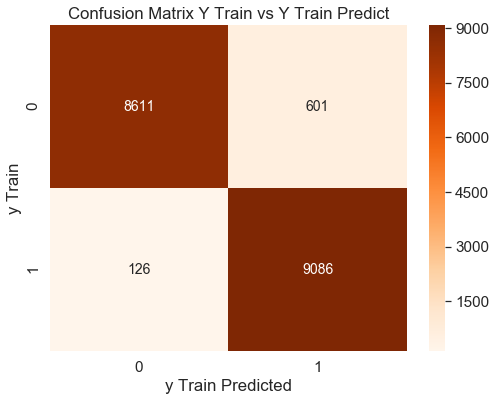

In [32]:
data = confusion_matrix(y_train, y_pred_train)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Train'
df_cm.columns.name = 'y Train Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Train vs Y Train Predict")
plt.show()

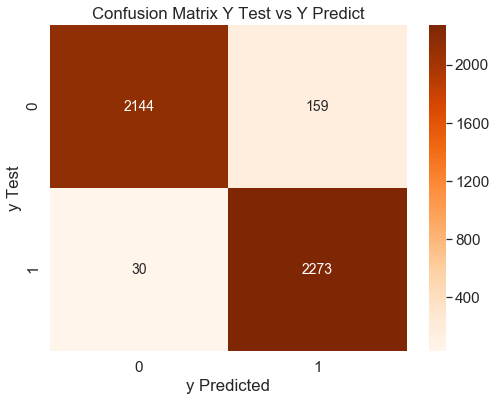

In [34]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'y Test'
df_cm.columns.name = 'y Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Oranges", annot=True,annot_kws={"size": 14},fmt='d')# font size
plt.title("Confusion Matrix Y Test vs Y Predict")
plt.show()

In [35]:
roc_auc_score(y_test, y_pred)

0.958966565349544

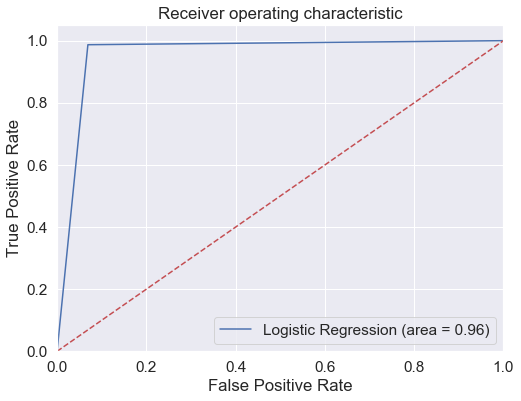

In [36]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Feature Importance

In [37]:
rfc_best.feature_importances_

array([4.35419304e-04, 8.07169632e-04, 1.52695534e-02, 1.85753278e-04,
       4.88493307e-05, 2.34480918e-03, 1.56562617e-04, 2.57693900e-04,
       1.34283953e-04, 6.09574813e-03, 4.10271692e-03, 1.33899482e-03,
       5.83433672e-03, 1.81805068e-03, 1.64941401e-03, 1.87915045e-04,
       8.19996864e-02, 2.61756991e-02, 2.19987288e-02, 2.95078564e-04,
       1.06187614e-04, 9.39002306e-05, 2.97519912e-04, 2.55744322e-04,
       1.30457658e-04, 3.87969286e-04, 2.67361630e-04, 4.29306266e-04,
       2.05823601e-04, 1.08357725e-04, 4.42346663e-04, 6.63112083e-04,
       3.52362382e-05, 1.83027760e-04, 3.15136297e-02, 5.73609535e-03,
       3.08319640e-02, 1.95724571e-03, 3.74156396e-02, 1.72738185e-02,
       5.49530757e-04, 3.04471850e-02, 3.97107536e-03, 1.22821099e-01,
       2.69305411e-02, 5.04482466e-01, 3.18982862e-04, 6.08630677e-03,
       4.92160516e-03])

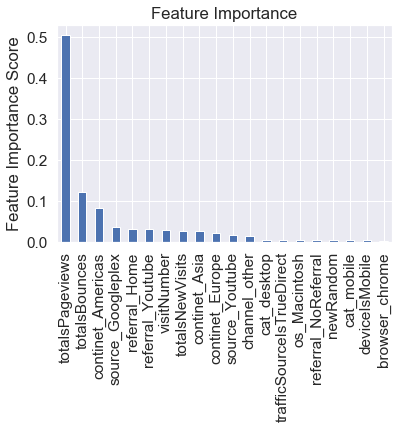

In [38]:
plot_feat_imp(rfc_best,20,df_downsampled.columns)

In [51]:
print_feat_imp(rfc_best,df_downsampled)

,Importance,Feature
0,0.5045,totalsPageviews
1,0.1228,totalsBounces
2,0.0820,continet_Americas
3,0.0374,source_Googleplex
4,0.0315,referral_Home
5,0.0308,referral_Youtube
6,0.0304,visitNumber
7,0.0269,totalsNewVisits
8,0.0262,continet_Asia
9,0.0220,continet_Europe


**CONCLUSIONS:**<br>
* The AUC, CM and F1 have given very good results.<br>
* The Pageviews, Bounces and the continent to be America have a 70% of importance in the model.<br>
* The column random is the 18th feature in importance, the rest of the columns can be avoided.

**IMPROVEMENTS:**<br>
* Improve the hyperparameter optimization of the model.
* Standarize the df to equal the vars range
* Take out the columns that perform under the random var